# Issue with contiguity masking Sentinel-2 at 10m resolution

## Sample query

In [168]:
import datacube 

dc = datacube.Datacube()

ymax, xmin = -35.089990, 150.681434
ymin, xmax = -35.141944, 150.734306

query = {
    'x': (xmin, xmax),
    'y': (ymax, ymin),
    'time': ('2018', '2018'),
    'measurements': ['nbart_red', 'nbart_green', 'nbart_blue', 'fmask'],
    'output_crs': 'EPSG:32756',
    'group_by': 'solar_day'
}


## Load and preview data at 20m resolution

In [169]:
# Load data
ds = dc.load(product='s2b_ard_granule', 
             resolution=(-20, 20),
             **query)

In [170]:
# ds.fmask.plot(col='time', col_wrap=4)

In [171]:
import odc.algo
mask = odc.algo.fmask_to_bool(ds.fmask, categories=['valid', 'snow', 'water'])

In [172]:
# mask.plot(col='time', col_wrap=4)

In [208]:
from skimage.morphology import disk
from skimage.morphology import binary_erosion, binary_dilation
import xarray as xr

def cloud_buffer(clouds_not, radius):

    base_dilation_radius = 10
    buffered = []

    for time, slc in clouds_not.groupby('time'):
        buffered_data = xr.DataArray(data=binary_erosion(binary_dilation(slc.data, disk(base_dilation_radius)), disk(base_dilation_radius + radius)), coords=slc.coords)
        buffered.append(buffered_data)

    return xr.concat(buffered, dim=clouds_not.time)

In [211]:
from skimage.morphology import binary_erosion, binary_closing

def cloud_buffer(da, radius=0, base_radius=10):

    # First remove small or narrow features using morphological closing
    mask_closing = binary_closing(da, disk(base_radius))
    
    # Then buffer remaining pixels by a radius to mask cloud edges
    mask_buffer = binary_erosion(mask_closing, disk(radius))
    
    return mask_buffer

new_mask = mask.groupby('time').apply(cloud_buffer)

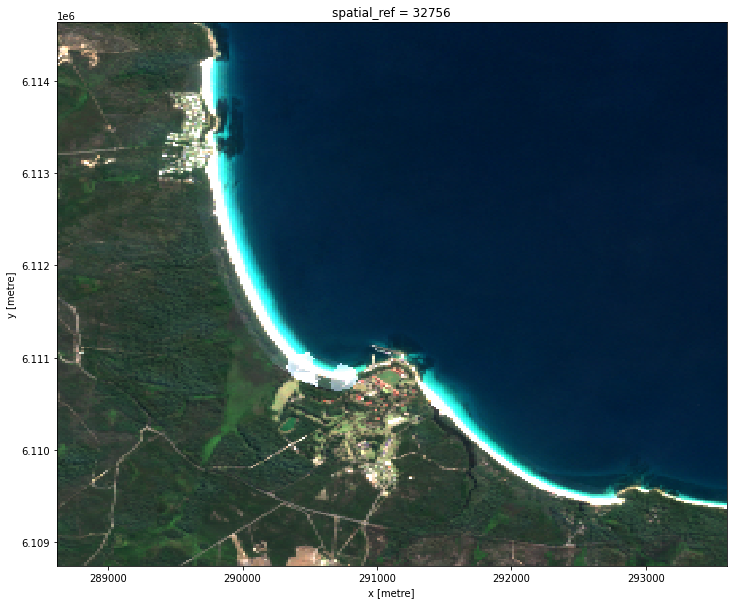

In [219]:
ds.where(mask)[['nbart_red', 'nbart_green', 'nbart_blue']].to_array().median(dim='time').plot.imshow(robust=True, size=10, aspect=1.2)

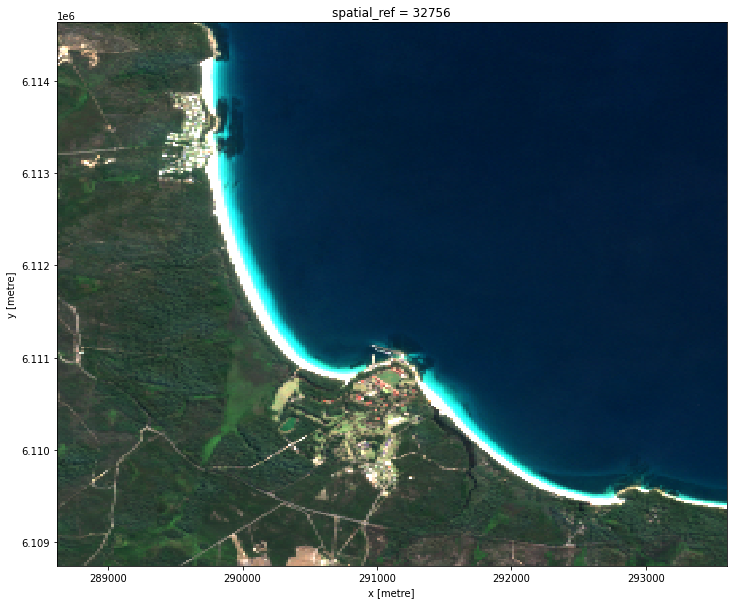

In [220]:
ds.where(new_mask)[['nbart_red', 'nbart_green', 'nbart_blue']].to_array().median(dim='time').plot.imshow(robust=True, size=10, aspect=1.2)

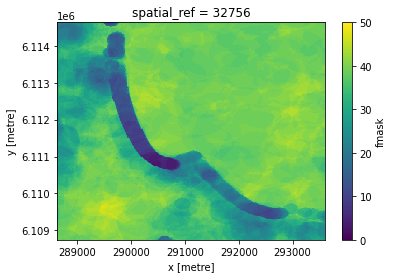

In [214]:
mask.sum(dim='time').plot(vmin=0, vmax=50)

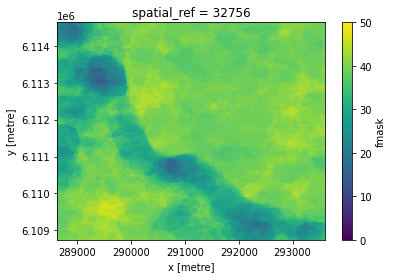

In [215]:
new_mask.sum(dim='time').plot(vmin=0, vmax=50)